# DBSCAN
DBSCAN is a density-based clustering algorithm. Its nice performance in comparison to other clustering algorithms is that it can detect clusters with arbritrary shape as long as they are connected in therms of density. DBSCAN implements the intuitive observation that the neighbours of a point's neighbour are also in the same neighbourhood.  

As a result, by following paths of points that are sufficiently close, we can identify a cluster.  

Main benefits:
- Not every points has to be assigned to a cluster, giving the possibility to detect outliers
- Number of clusters is not specified beforehand

In [1]:
%%html
<style>.container {width: 98%}</style>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import tab10
from scipy.spatial import KDTree

import sys
sys.path.insert(0, "../../")
from fromscratch.unsupervised.dbscan import DBSCAN

In [4]:
%matplotlib notebook

### Synthetic dataset with non-linear shapes

In [5]:
n1, n2, n3 = 200, 50, 7

theta = np.linspace(0, 2*np.pi, n1)
X1 = np.stack((
    3*np.cos(theta) + np.random.normal(0, 0.3, n1),
    3*np.sin(theta) + np.random.normal(0, 0.3, n1)
)).T

theta = np.linspace(0, 2*np.pi, n2)
X2 = np.stack((
    0.5*np.cos(theta) + np.random.normal(0, 0.2, n2),
    0.5*np.sin(theta) + np.random.normal(0, 0.2, n2)
)).T

theta = np.linspace(0, 2*np.pi, n3)
X3 = np.stack((
    2*np.cos(theta) + np.random.normal(0, 0.3, n3),
    2*np.sin(theta) + np.random.normal(0, 0.3, n3)
)).T

X = np.vstack((X1, X2, X3))

y = np.array([1]*n1 + [2]*n2 + [3]*n3)  # underlying/unknown data clustering

<IPython.core.display.Javascript object>


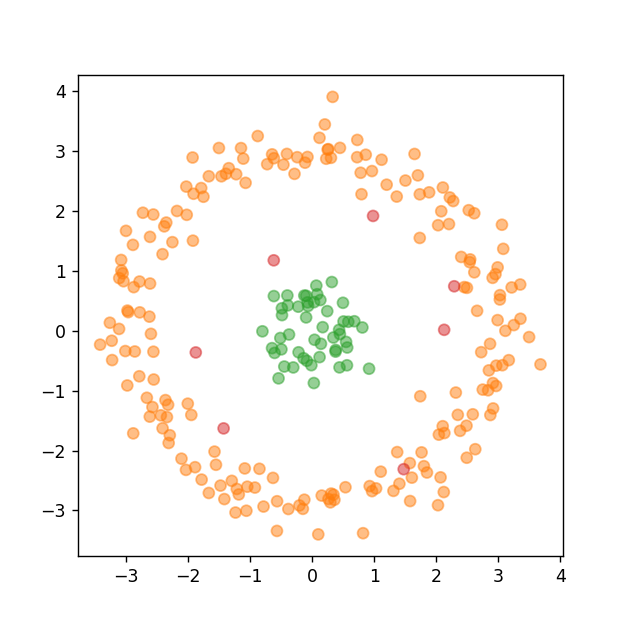

In [6]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=[tab10(i) for i in y], alpha=0.5, s=40)
plt.show()

### Run DBSCAN

In [7]:
epsilon = 0.6
min_samples = 3

dbscan = DBSCAN(epsilon=epsilon, min_samples=min_samples)

In [8]:
dbscan.fit(X)

<IPython.core.display.Javascript object>


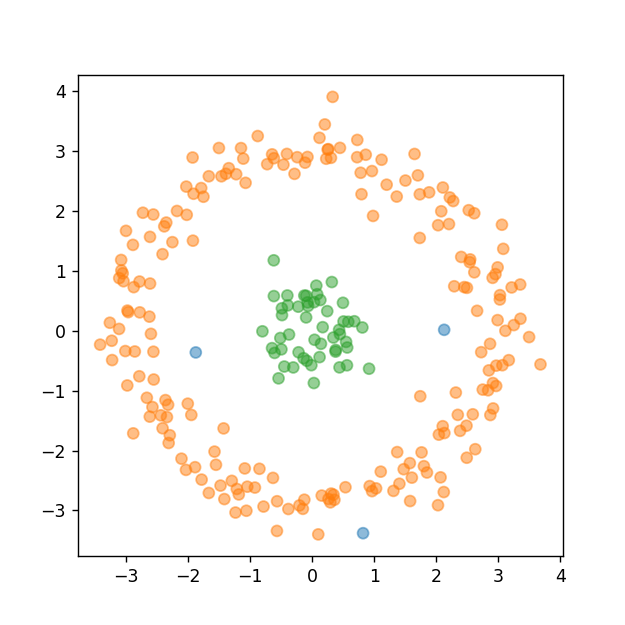

In [9]:
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=[tab10(i) for i in dbscan.cluster], alpha=0.5, s=40)
plt.show()

Clusters and noise are nicely identified

### DBSCAN Animation
The code below (simplified/uncommented version of the respective dbscan.py script) visualizes in real-time how samples are selected by the DBSCAN algorithm, how chains of accessible points form a cluster and how noise are left out from all clusters. 

In [10]:
kdtree = KDTree(X)

In [11]:
def get_accessible_points_inds(ind_x, X):
    x = X[ind_x, :]
    
    inds = kdtree.query_ball_point(x, epsilon)
    inds.remove(ind_x)
    
    return inds

<IPython.core.display.Javascript object>


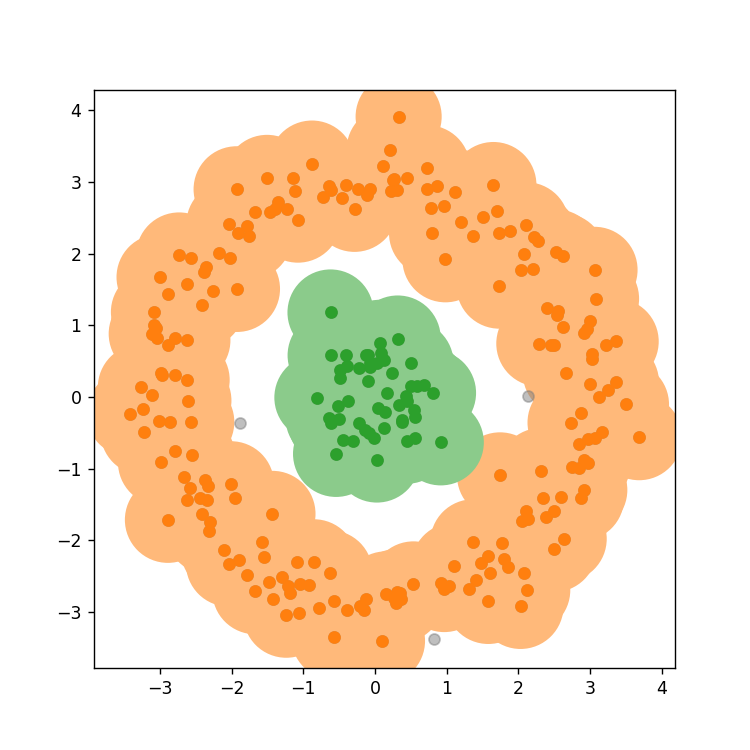

In [12]:
m = 0
cluster = np.array([None]*X.shape[0])

plt.ion()
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.axis("equal")
ax.set_xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
ax.set_ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)

ax.scatter(X[:, 0], X[:, 1], c="grey", alpha=0.5, s=40)
fig.canvas.draw()

current_plot = None
for i, x in enumerate(X):
    if cluster[i] is not None:
        continue
        
    neighbour_inds = get_accessible_points_inds(i, X)
    if len(neighbour_inds) < min_samples:
        cluster[i] = 0
        continue
    
    m += 1
    cluster[i] = m
    
    color = tab10(m)
    light_color = tuple([e + (0.45 * (1 - e)) for e in tab10(m)])[0:-1] + (1,)
    
    current_plot.set_visible(False) if current_plot is not None else None
    if cluster[i] != 0:
        ax.add_patch(plt.Circle(x, radius=epsilon, fc=light_color, ec=(0,0,0,0), zorder=-X.shape[0]-1, lw=0))
    current_plot = ax.add_patch(plt.Circle(x, radius=epsilon, fc=(0, 0, 0, 0), ec="red", color="red"))
    fig.canvas.draw()
    ax.scatter([x[0]], [x[1]], c=[color], alpha=1.0, s=40)
    
    while True:
        if len(neighbour_inds) <= 0:
            break
        
        j = neighbour_inds[0]
        neighbour_inds = neighbour_inds[1:]
        
        if cluster[j] is not None:
            continue
            
        x_ = X[j, :]
        
        cluster[j] = m
        
        ax.scatter([x_[0]], [x_[1]], c=[color], alpha=1.0, s=40)
        if cluster[j] != 0:
            ax.add_patch(plt.Circle(x_, radius=epsilon, fc=light_color, ec=(0,0,0,0), zorder=-X.shape[0]-1, lw=0))
        current_plot.set_visible(False) if current_plot is not None else None
        current_plot = ax.add_patch(plt.Circle(x_, radius=epsilon, fc=(0,0,0,0), ec="red"))
        fig.canvas.draw()
        
        neighbour_inds_j = get_accessible_points_inds(j, X)
        neighbour_inds.extend(list(set(neighbour_inds_j) - set(neighbour_inds)))
        
current_plot.set_visible(False) if current_plot is not None else None